# Airbnb Berlin – Multiple Linear Regression Project

**Author:** Tan Shi Wei  
 
**Date:** 13/9/2025  

**Dataset Source:** [Inside Airbnb – Get The Data](http://insideairbnb.com/get-the-data.html)

*Data used under the InsideAirbnb Community Guidelines. The raw dataset is not redistributed in this repository — please download it directly from the InsideAirbnb website if you wish to replicate this analysis.*

**Attribution:** The data and variable definitions are provided by the InsideAirbnb project, which makes Airbnb data available for research and policy discussions.

## 1️⃣ Project Overview

This project explores Airbnb listings in Berlin to predict listing prices using a multiple linear regression model.  

**Objectives:**
- Understand the data and its features.
- Perform preprocessing and feature analysis.
- Train and evaluate a multiple linear regression model.
- Interpret results and visualize predicted vs actual prices.

## 2️⃣ Dataset Information

**Files Used:**
- `listings.csv` – Summary and detailed information for Airbnb listings in Berlin.

**Key Features Considered:**

> **Note:** This table highlights a small portion of the full Airbnb dataset. For the complete data dictionary, please refer to the [Inside Airbnb Data Dictionary](http://insideairbnb.com/get-the-data.html).

| Feature | Type | Description |
|---------|------|-------------|
| accommodates | Numerical | Number of guests the listing can host |
| bedrooms | Numerical | Number of bedrooms in the listing |
| bathrooms | Numerical | Number of bathrooms in the listing |
| number_of_reviews | Numerical | Total number of reviews received by the listing |
| review_scores_rating | Numerical | Average guest review rating (out of 100) |
| room_type | Categorical (OHE) | Type of room: Entire home/apt, Private room, Shared room, Hotel room |
| property_type | Categorical (OHE) | Type of property: Apartment, House, Loft, etc. |
| neighbourhood_cleansed | Categorical (OHE) | Administrative neighbourhood of the listing |
| latitude | Numerical | Geographic latitude of the listing |
| longitude | Numerical | Geographic longitude of the listing |
| price | Target (Numerical) | Listing price per night (in local currency) |


**Notes:**
- Price contains currency symbols and must be converted to numeric.
- Some listings have missing values in key columns and extreme price outliers.
- Categorical features require one-hot encoding for regression.

## 3️⃣ Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 4️⃣ Load Dataset

In [2]:
# Load listings data
listings = pd.read_csv('data/listings.csv')

# Preview the first few rows
listings.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176,https://www.airbnb.com/rooms/3176,20250620182343,2025-06-21,city scrape,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/airflow/Hosti...,3718,...,4.70,4.92,4.61,NaN,f,1,1,0,0,0.76
1,9991,https://www.airbnb.com/rooms/9991,20250620182343,2025-06-21,city scrape,Geourgeous flat - outstanding views,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852,...,5.00,4.86,4.86,03/Z/RA/003410-18,f,1,1,0,0,0.06
2,14325,https://www.airbnb.com/rooms/14325,20250620182343,2025-06-21,city scrape,Studio Apartment in Prenzlauer Berg,The apartment is located on the upper second f...,NaN,https://a0.muscache.com/pictures/508703/24988a...,55531,...,4.85,4.60,4.45,NaN,f,4,4,0,0,0.14


## 5️⃣ Data Cleaning & Merging

Steps:
- Drop irrelevant columns from listings.
- Remove rows with `NA` values.
- Convert `price` to numeric.
- Remove extreme outliers for `price`.

In [3]:
# Define the minimal feature set
keep_cols = [
    'accommodates',
    'bedrooms',
    'bathrooms',
    'room_type',
    'property_type',
    'neighbourhood_cleansed',
    'price',
    'review_scores_rating',
    'number_of_reviews']

# Keep only the relevant columns that exist in the dataset
listings = listings[keep_cols]

# Handle missing values in key features
listings.dropna(inplace = True)

# Convert price to numeric
listings['price'] = [float(price.replace('$', '').replace(',', '')) for price in listings['price']]

In [4]:
price_stats = listings.groupby('property_type')['price'].agg(['min', 'max', 'median']) # Compute min, max, and median
price_stats['range'] = price_stats['max'] - price_stats['min'] # Compute range
price_stats['count'] = listings['property_type'].value_counts() # Add count of listings per property_type
price_stats = price_stats.sort_values(by = 'range', ascending = False) # Sort by descending range
print(price_stats.head(10)) # Display top 10

                              min      max  median    range  count
property_type                                                     
Room in hotel                38.0  50000.0   154.0  49962.0    194
Entire rental unit           21.0  10000.0   126.0   9979.0   3810
Entire home                  48.0   9999.0   166.0   9951.0    102
Entire loft                  46.0   2500.0   154.0   2454.0    161
Shared room in hostel        13.0   2310.0    33.0   2297.0     48
Houseboat                    31.0   1306.0   236.0   1275.0     30
Entire guest suite           50.0   1050.0   129.0   1000.0     17
Private room in rental unit   5.0    940.0    63.0    935.0   1040
Entire condo                 24.0    833.0   135.0    809.0    467
Room in aparthotel           45.0    840.0   159.0    795.0     41


The table shows descriptive statistics of Airbnb listing prices by `property_type`. While the median prices are generally moderate (e.g., 126–166 for most common types), the maximum prices are extreme, leading to very large ranges (e.g., “Room in hotel” has a range of 49,962). This highlights the presence of substantial outliers in certain property types, particularly those with fewer listings or luxury options. The count column shows that these extremes do not represent the majority of listings, reinforcing the need to remove outliers to prevent them from disproportionately influencing the model.

In [5]:
# Remove price outliers (top 1%)

min_group_size = 10
group_sizes = listings['property_type'].value_counts() # Get property types with enough listings
valid_groups = group_sizes[group_sizes >= min_group_size].index
filtered_list = [] # Initialize an empty list to collect filtered DataFrames

for group in valid_groups:
    group_prices = listings.loc[listings['property_type'] == group, 'price'] # Select prices for the current group
    upper_limit = group_prices.quantile(0.95) # Compute 99th percentile for this group
    filtered_group = listings.loc[(listings['property_type'] == group) & (listings['price'] < upper_limit)] # Filter rows below the 99th percentile
    if not filtered_group.empty:
        filtered_list.append(filtered_group)

listings = pd.concat(filtered_list, ignore_index = True) # Combine all filtered groups

listings.head()

,accommodates,bedrooms,bathrooms,room_type,property_type,neighbourhood_cleansed,price,review_scores_rating,number_of_reviews
0,2,1.0,1.0,Entire home/apt,Entire rental unit,Prenzlauer Berg Südwest,105.0,4.63,149
1,7,4.0,2.5,Entire home/apt,Entire rental unit,Prenzlauer Berg Südwest,135.0,5.00,7
2,1,0.0,1.0,Entire home/apt,Entire rental unit,Prenzlauer Berg Nordwest,75.0,4.68,26
3,2,0.0,1.0,Entire home/apt,Entire rental unit,Reuterstraße,28.0,4.77,298
4,2,2.0,1.0,Entire home/apt,Entire rental unit,Brunnenstr. Süd,53.0,4.70,182


## 6️⃣ Feature Engineering

- Select numerical and categorical features.
- One-hot encode, group encode and target encode categorical variables.
- Standardize numerical features.
- Split data into training and test sets.

In [6]:
cat_features = ['room_type', 'property_type', 'neighbourhood_cleansed']

listings[cat_features].nunique()

room_type                   4
property_type              30
neighbourhood_cleansed    135
dtype: int64

If one-hot encoding (OHE) were applied to these variables, it would create a sparse matrix, especially for `neighbourhood_cleansed`, which has 135 unique categories, resulting in many columns with mostly zeros.

| Encoding Type       | How It Works in Airbnb Dataset                         | Pros                                        | Cons / Notes                                  |
|--------------------|--------------------------------------------------------|--------------------------------------------|-----------------------------------------------|
| One-Hot Encoding    | `room_type` → separate column for each type            | Easy to implement, interpretable           | Creates many columns if too many categories   |
| Grouped Encoding    | Rare `property_type` grouped as "Other"               | Reduces columns, handles rare types        | Loses detail for rare property types          |
| Target Encoding     | `neighbourhood_cleansed` → average `price` per area   | Captures price trends by neighborhood      | Reveals target values to the model during training.     |

In [7]:
# Numerical features
num_features = [
    'accommodates',
    'bedrooms',
    'bathrooms',
    'review_scores_rating',
    'number_of_reviews']

# Initialize encoder
encoder = OneHotEncoder(sparse_output = False, drop = 'first')

# Grouped rare property types
threshold = 0.01  
prop_counts = listings['property_type'].value_counts(normalize = True)
rare_props = prop_counts[prop_counts < threshold].index
listings['property_type_grouped'] = listings['property_type'].replace(rare_props, 'Other')

# OHE room_type and property_type_grouped together
X_cat = encoder.fit_transform(listings[['room_type', 'property_type_grouped']])

# Target Encode neighbourhood_cleansed
target_encoder = ce.TargetEncoder(cols = ['neighbourhood_cleansed'])
X_neigh = target_encoder.fit_transform(listings[['neighbourhood_cleansed']], listings['price'])

# Combine numerical features with target-encoded neighbourhood
X_num_combined = pd.concat([listings[num_features].reset_index(drop = True), X_neigh.reset_index(drop = True)], axis=1)

# Scale numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_combined)

# Combine all features
X = np.hstack([X_num_scaled, X_cat])
y = listings['price'].to_numpy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 7️⃣ Modeling – Multiple Linear Regression

In [8]:
# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

## 8️⃣ Model Evaluation

Train MSE: 2291.99
Test MSE: 2311.65
Train R²: 0.536
Test R²: 0.534


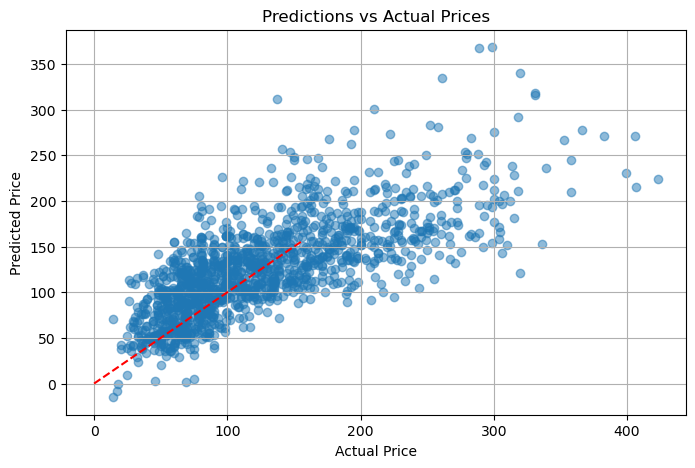

In [9]:
# Metrics
print(f"Train MSE: {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")

# Plot predicted vs actual prices
plt.figure(figsize = (8, 5))
plt.scatter(y_test, y_pred_test, alpha = 0.5)
plt.plot([0, upper_limit],[0, upper_limit], color = 'red', linestyle = '--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predictions vs Actual Prices")
plt.grid(True)
plt.show()

The model shows moderate predictive performance, with a training MSE of 2291.99 and test MSE of 2311.65, indicating that on average the squared difference between predicted and actual prices is ~2300. The R² values of 0.536 on the training set and 0.534 on the test set suggest that the model explains roughly 53% of the variance in price and generalizes reasonably well to unseen data.

## 9️⃣ Feature Importance

Although linear regression coefficients can indicate importance, standardization helps in comparing feature influence.

In [10]:
# OHE feature names
ohe_feature_names = encoder.get_feature_names_out()

# Combine all feature names
feature_names = list(num_features) + list(ohe_feature_names) + ['neighbourhood_cleansed']

# Feature importance ranked by absolute coefficient values
coefficients_abs = pd.Series(lr_model.coef_, index = feature_names)
coefficients_ranked = coefficients_abs.reindex(coefficients_abs.abs().sort_values(ascending = False).index)

# Show top 10 features by absolute importance
coefficients_ranked.head(10)

property_type_grouped_Entire home                   -116.514110
property_type_grouped_Other                           58.201415
property_type_grouped_Private room in rental unit    -45.456918
room_type_Private room                                45.120964
neighbourhood_cleansed                                38.432097
property_type_grouped_Room in hotel                  -37.915892
property_type_grouped_Private room in home           -34.955390
accommodates                                          24.355515
room_type_Hotel room                                  15.487973
bedrooms                                              12.496238
dtype: float64

The feature importance shows that `property_type_grouped_Entire home` has the largest negative impact on price, while `property_type_grouped_Other` has a strong positive effect. Other significant features include `room_type_Private room` and `neighbourhood_cleansed`, indicating that both the type of property and the neighborhood are important drivers of Airbnb listing prices. Among numerical features, `accommodates` and `bedrooms` also contribute positively, but to a lesser extent.

## 🔟 Conclusion

The multiple linear regression model predicts Airbnb listing prices using a combination of numerical, categorical, and aggregated review features. Model performance, evaluated via MSE and R² on both training and test sets, indicates a reasonable fit. Visual inspection of predicted versus actual prices confirms this, although some variability remains, likely due to factors such as location, property type, and seasonal demand.

Potential avenues for improvement include:

- Incorporating time-based features from reviews.csv to capture recency and trends in ratings.

- Adding spatial features, such as distance to landmarks or neighborhood characteristics.

- Applying regularized regression methods (Ridge, Lasso) to mitigate multicollinearity and reduce overfitting.